# PROVA INTELIGÊNCIA ARTIFICIAL
### Aluno: Kelvin Brenand - 20180005270

# Imports

In [ ]:
#Rodar as linhas inferiores caso algum problema ocorra com a próxima célula. 
#Após a instalação, a runtime deve ser reiniciada.
 
# !sudo apt-get install build-essential swig
# !pip install auto-sklearn==0.14.7

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import autosklearn.classification
import warnings
warnings.filterwarnings('ignore')

# Questão 1

## Modelo Controle (Todos os atributos)

In [ ]:
dataset = pd.read_csv("https://drive.google.com/uc?export=download&id=16gKKKP04qM46B_x-A6HreLEJBA7Urm6A")

In [ ]:
X = dataset.iloc[:, 1:31].values #Retira apenas STUDENTID (indices das rows)
y = dataset.iloc[:, 32].values #Separa os labels

In [ ]:
#Como demandado, a validação cruzada estratificada 10-fold com random_state fixo
#é utilizada
X_train = []
X_test = []
y_train = []
y_test = []

skf = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
for train_index, test_index in skf.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

In [ ]:
#Shape final dos dados
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(131, 30) (131,)
(14, 30) (14,)


In [ ]:
#Treinamento do automl com 5min de treinamento
automl = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=5*60)
automl.fit(X_train, y_train, dataset_name='Higher Education Students Performance Evaluation')

[WARNING] [2022-05-27 22:38:18,714:Client-AutoML(1):Higher Education Students Performance Evaluation] Unknown dtype for X: int64, assuming it takes 8 bit/number


AutoSklearnClassifier(per_run_time_limit=30, time_left_for_this_task=300)

In [ ]:
#Ranking dos algoritmos
print(automl.leaderboard())

          rank  ensemble_weight                type      cost  duration
model_id                                                               
26           1             0.04       random_forest  0.704545  1.744660
58           2             0.08       decision_tree  0.704545  0.859442
6            3             0.02          libsvm_svc  0.750000  1.742862
12           4             0.04   gradient_boosting  0.750000  1.047925
49           5             0.02            adaboost  0.750000  1.700723
55           6             0.04                 qda  0.750000  0.830315
57           7             0.02          libsvm_svc  0.750000  0.827302
2            8             0.02       random_forest  0.772727  3.636356
3            9             0.04       random_forest  0.772727  3.259233
22          10             0.08       random_forest  0.772727  2.006397
61          11             0.02       decision_tree  0.772727  0.825128
41          12             0.04                 lda  0.772727  0

In [ ]:
#Matriz de confusão do automl
print(sklearn.metrics.confusion_matrix(y_test, automl.predict(X_test)))

[[0 1 0 0 0 0 0 0]
 [0 2 0 0 0 0 1 0]
 [0 2 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 1]
 [0 2 0 0 0 0 0 0]]


In [ ]:
#Baixa acurácia. O modelo não aprendeu a classificar os dados de forma correta
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, automl.predict(X_test)))

Accuracy score 0.2857142857142857


## Pré-processamento

In [ ]:
#Recarrega o dataset
dataset = pd.read_csv("https://drive.google.com/uc?export=download&id=16gKKKP04qM46B_x-A6HreLEJBA7Urm6A")
dataset = dataset.drop('STUDENTID', axis=1) #Remove 'STUDENTID'

In [ ]:
#Exibe as infos iniciais
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   AGE            145 non-null    int64
 1   GENDER         145 non-null    int64
 2   HS_TYPE        145 non-null    int64
 3   SCHOLARSHIP    145 non-null    int64
 4   WORK           145 non-null    int64
 5   ACTIVITY       145 non-null    int64
 6   PARTNER        145 non-null    int64
 7   SALARY         145 non-null    int64
 8   TRANSPORT      145 non-null    int64
 9   LIVING         145 non-null    int64
 10  MOTHER_EDU     145 non-null    int64
 11  FATHER_EDU     145 non-null    int64
 12  #_SIBLINGS     145 non-null    int64
 13  KIDS           145 non-null    int64
 14  MOTHER_JOB     145 non-null    int64
 15  FATHER_JOB     145 non-null    int64
 16  STUDY_HRS      145 non-null    int64
 17  READ_FREQ      145 non-null    int64
 18  READ_FREQ_SCI  145 non-null    int64
 19  ATTEND_D

In [ ]:
#Utils
def Label_enc(param):
    LabelE = LabelEncoder()
    LabelE.fit(param)
    return LabelE.transform(param)

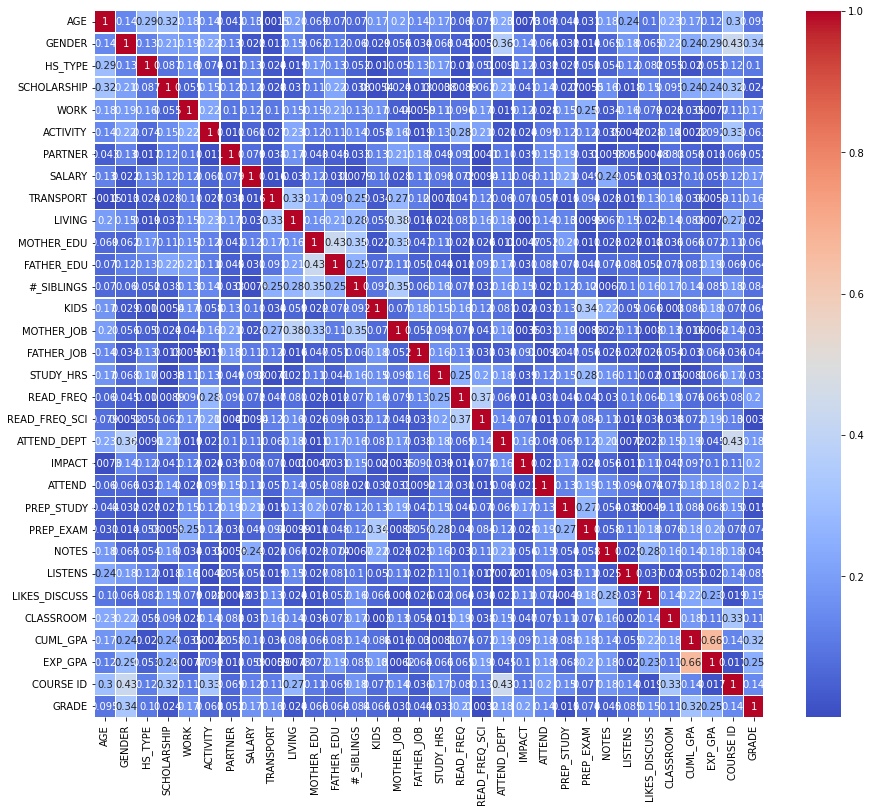

In [ ]:
#Verifica a correlação das features
df_bis = dataset.copy()
df_bis["GRADE"] = Label_enc(df_bis["GRADE"])
tabcorr = df_bis.corr()
plt.figure(figsize=(15,13))
sns.heatmap(abs(tabcorr), annot=True, linewidths=.5,  cmap="coolwarm")

In [ ]:
#Remove os atributos que não foram considerados como fortes contribuidores para 
#o modelo ou que não são pertinentes, como o atributo 'PARTNER'.
dataset = dataset.drop(['SCHOLARSHIP', 'PARTNER', 'TRANSPORT', 'LIVING'], axis=1)
dataset = dataset.drop(['MOTHER_EDU', '#_SIBLINGS', 'KIDS', 'MOTHER_JOB'], axis=1)
dataset = dataset.drop(['FATHER_JOB', 'READ_FREQ_SCI', 'PREP_STUDY'], axis=1)
dataset = dataset.drop(['PREP_EXAM', 'CLASSROOM', 'EXP_GPA', 'COURSE ID'], axis=1)

In [ ]:
#Infos após a remoção de alguns atributos
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   AGE            145 non-null    int64
 1   GENDER         145 non-null    int64
 2   HS_TYPE        145 non-null    int64
 3   WORK           145 non-null    int64
 4   ACTIVITY       145 non-null    int64
 5   SALARY         145 non-null    int64
 6   FATHER_EDU     145 non-null    int64
 7   STUDY_HRS      145 non-null    int64
 8   READ_FREQ      145 non-null    int64
 9   ATTEND_DEPT    145 non-null    int64
 10  IMPACT         145 non-null    int64
 11  ATTEND         145 non-null    int64
 12  NOTES          145 non-null    int64
 13  LISTENS        145 non-null    int64
 14  LIKES_DISCUSS  145 non-null    int64
 15  CUML_GPA       145 non-null    int64
 16  GRADE          145 non-null    int64
dtypes: int64(17)
memory usage: 19.4 KB


In [ ]:
#Busca por dados duplicados
duplicate = [True for x in dataset.duplicated() if x == True]
print(duplicate) #Sem dados duplicados

[]


### Análise Exploratória

In [ ]:
#Separa os dados das suas classes (labels)
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

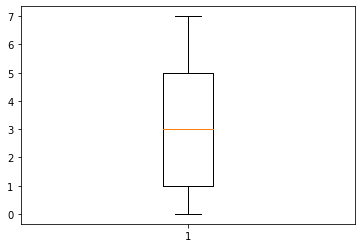

In [ ]:
#Boxplot inicial das classes.
plt.boxplot(y)
plt.show()

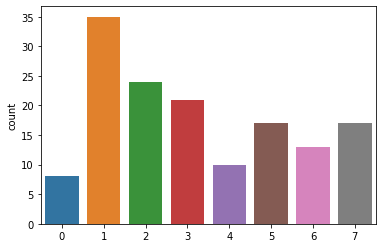

In [ ]:
#Classes desbalanceadas
sns.countplot(y,label="Count")
plt.show()

In [ ]:
#Performa o oversample para balancear as classes
osNumber = 35
oversample = RandomOverSampler(sampling_strategy={0:osNumber,2:osNumber,3:osNumber,4:osNumber,5:osNumber,6:osNumber,7:osNumber})
X, y = oversample.fit_resample(X, y)

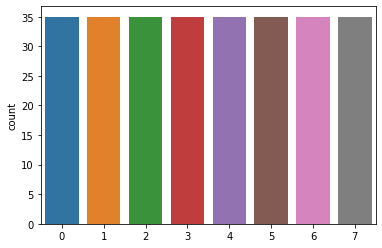

In [ ]:
#Dados balanceados
sns.countplot(y,label="Count")
plt.show()

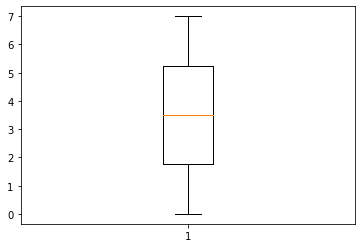

In [ ]:
#Boxplot final das classes. 
#Ao examinar os dois boxplots, é possível observar que o segundo está 
#centralizado enquanto que o primeiro estava sendo "puxado" para baixo pela 
#classe '1', devido ao desbalancemanento. Ou seja, o primeiro quantil é composto
#basicamente apenas de elementos da classe '1'. Além disso, não há presença de 
#outliers em nenhum dos dois boxplots.
plt.boxplot(y)
plt.show()

In [ ]:
#Como demandado, a validação cruzada estratificada 10-fold com random_state fixo
#é utilizada
X_train = []
X_test = []
y_train = []
y_test = []

skf = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
for train_index, test_index in skf.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

In [ ]:
#Normalização dos dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#Shape final dos dados
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(252, 16) (252,)
(28, 16) (28,)


## Treinamento com Automl e com o melhor algoritmo

In [ ]:
#Treinamento do automl com 5min de treinamento
automl = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=5*60)
automl.fit(X_train, y_train, dataset_name='Higher Education Students Performance Evaluation')

AutoSklearnClassifier(per_run_time_limit=30, time_left_for_this_task=300)

In [ ]:
#Ranking dos algoritmos
print(automl.leaderboard())

          rank  ensemble_weight                type      cost   duration
model_id                                                                
28           1             0.02          libsvm_svc  0.190476   0.997115
2            2             0.02       random_forest  0.214286   1.886180
55           3             0.02          libsvm_svc  0.226190   0.826480
49           4             0.02          libsvm_svc  0.226190   1.006454
40           5             0.04          libsvm_svc  0.226190   1.070220
12           6             0.02                 lda  0.238095   3.844363
58           7             0.04          libsvm_svc  0.250000   0.815151
44           8             0.06          libsvm_svc  0.250000   0.812907
35           9             0.06       random_forest  0.250000   2.242944
17          10             0.02          libsvm_svc  0.250000   0.824724
24          11             0.06   gradient_boosting  0.273810   6.008082
10          12             0.02       random_forest

In [ ]:
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, automl.predict(X_test)))

Accuracy score 0.6785714285714286


In [ ]:
#Random Forest foi o melhor algoritmo, apesar dele nem sempre aperecer no topo, 
#devido à natureza não-deterministica do automl.
#Abaixo, o parâmetro 'max_features' é utilizado em 3 variações, porém a acurácia
#não se altera.
clf = RandomForestClassifier(n_estimators = 1000,max_depth=10,oob_score=True, max_features="sqrt").fit(X_train, y_train)
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, clf.predict(X_test)))

Accuracy score 0.8571428571428571


In [ ]:
clf = RandomForestClassifier(n_estimators = 1000,max_depth=10,oob_score=True, max_features="log2").fit(X_train, y_train)
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, clf.predict(X_test)))

Accuracy score 0.8571428571428571


In [ ]:
clf = RandomForestClassifier(n_estimators = 1000,max_depth=10,oob_score=True, max_features=None).fit(X_train, y_train)
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, clf.predict(X_test)))

Accuracy score 0.8571428571428571


## Resultados

In [ ]:
#Matriz de confusão do automl
#Nota-se que houveram poucos erros. De maneira geral, as classes foram preditas
#de forma correta. 
print(sklearn.metrics.confusion_matrix(y_test, automl.predict(X_test)))

[[4 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0]
 [0 1 1 0 0 2 0 0]
 [0 0 0 3 0 0 0 0]
 [0 0 0 0 2 0 2 0]
 [0 0 0 0 0 3 0 0]
 [0 0 0 0 0 1 3 0]
 [0 0 0 0 0 0 1 2]]


In [ ]:
#Matriz de confusão da Random Forest
#É possivel observer que o desempenho exclusivamente do Random Forest é superior 
#ao do 'ensemble' dos algoritmos que o automl faz. Isso se deve ao 
#hyperparameter tuning feito no Random Forest
print(sklearn.metrics.confusion_matrix(y_test, clf.predict(X_test)))

[[4 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0]
 [0 0 3 0 1 0 0 0]
 [0 0 0 3 0 0 0 0]
 [0 0 0 0 4 0 0 0]
 [0 0 0 0 0 3 0 0]
 [0 0 0 0 0 1 3 0]
 [0 0 0 0 0 0 0 3]]


In [ ]:
#Classification Report do automl
#Nota-se uma boa acurácia, o que significa que o modelo aprendeu relativamente
#bem a classificar os dados. Além disso, com a métrica precision, vemos que, 
#para todas as classes, uma alta proporção de identificações positivas estavam 
#realmente corretas. 
print(sklearn.metrics.classification_report(y_test, automl.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.50      0.33      0.40         3
           2       0.50      0.25      0.33         4
           3       1.00      1.00      1.00         3
           4       1.00      0.50      0.67         4
           5       0.50      1.00      0.67         3
           6       0.50      0.75      0.60         4
           7       1.00      0.67      0.80         3

    accuracy                           0.68        28
   macro avg       0.72      0.69      0.67        28
weighted avg       0.72      0.68      0.66        28



In [ ]:
#Classification Report do Random Forest
#De forma similar à matriz de confusão, as métricas do Random Forest em isolado
#são bem melhores que as métricas do automl.
print(sklearn.metrics.classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.33      0.50         3
           2       0.75      0.75      0.75         4
           3       1.00      1.00      1.00         3
           4       0.80      1.00      0.89         4
           5       0.75      1.00      0.86         3
           6       1.00      0.75      0.86         4
           7       1.00      1.00      1.00         3

    accuracy                           0.86        28
   macro avg       0.89      0.85      0.84        28
weighted avg       0.88      0.86      0.84        28



In [ ]:
#Considerando que a acurácia do modelo controle (todos os atributos) foi de 0.29
#e que a acurácia do modelo com redimensionamento de atributos foi de 0.86, 
#nota-se o impacto do redimensionamento das features atrelado ao 
#pré-processamento dos dados para o aumento significativo do aprendizado.

# Questão 2

## Sem pré-processamento

In [ ]:
#Carregamento dos dados
dataset = pd.read_csv("https://drive.google.com/uc?export=download&id=16gKKKP04qM46B_x-A6HreLEJBA7Urm6A")

dataset = dataset.drop('STUDENTID', axis=1) #Remove 'STUDENTID'

X = dataset.iloc[:, :-1].values #Remoção do rótulo
y = dataset.iloc[:, -1].values

### K-Means

In [ ]:
#KMeans variando n_clusters
kmeans = KMeans(n_clusters=5, random_state=0).fit_predict(X)
KM1 = sklearn.metrics.rand_score(y, kmeans)
print("Rand index score", KM1)

Rand index score 0.6993295019157089


In [ ]:
kmeans = KMeans(n_clusters=7, random_state=0).fit_predict(X)
KM2 = sklearn.metrics.rand_score(y, kmeans)
print("Rand index score", KM2)

Rand index score 0.7576628352490421


### Hierárquico

In [ ]:
#Hierárquico variando n_clusters e linkage
clustering = AgglomerativeClustering(n_clusters=5, linkage='average').fit_predict(X)
H1 = sklearn.metrics.rand_score(y, clustering)
print("Rand index score", H1)

Rand index score 0.5327586206896552


In [ ]:
clustering = AgglomerativeClustering(n_clusters=5, linkage='ward').fit_predict(X)
H2 = sklearn.metrics.rand_score(y, clustering)
print("Rand index score", H2)

Rand index score 0.7118773946360153


In [ ]:
clustering = AgglomerativeClustering(n_clusters=7, linkage='average').fit_predict(X)
H3 = sklearn.metrics.rand_score(y, clustering)
print("Rand index score", H3)

Rand index score 0.571551724137931


In [ ]:
clustering = AgglomerativeClustering(n_clusters=7, linkage='ward').fit_predict(X)
H4 = sklearn.metrics.rand_score(y, clustering)
print("Rand index score", H4)

Rand index score 0.7331417624521073


## Com pré-processamento

In [ ]:
#Carregamento dos dados com pré-processamento
dataset = pd.read_csv("https://drive.google.com/uc?export=download&id=16gKKKP04qM46B_x-A6HreLEJBA7Urm6A")

dataset = dataset.drop('STUDENTID', axis=1)
dataset = dataset.drop(['SCHOLARSHIP', 'PARTNER', 'TRANSPORT', 'LIVING'], axis=1)
dataset = dataset.drop(['MOTHER_EDU', '#_SIBLINGS', 'KIDS', 'MOTHER_JOB'], axis=1)
dataset = dataset.drop(['FATHER_JOB', 'READ_FREQ_SCI', 'PREP_STUDY'], axis=1)
dataset = dataset.drop(['PREP_EXAM', 'CLASSROOM', 'EXP_GPA', 'COURSE ID'], axis=1)

X = dataset.iloc[:, :-1].values #Remoção do rótulo
y = dataset.iloc[:, -1].values

osNumber = 35
oversample = RandomOverSampler(sampling_strategy={0:osNumber,2:osNumber,3:osNumber,4:osNumber,5:osNumber,6:osNumber,7:osNumber})
X, y = oversample.fit_resample(X, y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

### K-Means

In [ ]:
#KMeans variando n_clusters
kmeans = KMeans(n_clusters=5, random_state=0).fit_predict(X)
KM3 = sklearn.metrics.rand_score(y, kmeans)
print("Rand index score", KM3)

Rand index score 0.7191244239631336


In [ ]:
kmeans = KMeans(n_clusters=7, random_state=0).fit_predict(X)
KM4 = sklearn.metrics.rand_score(y, kmeans)
print("Rand index score", KM4)

Rand index score 0.7854070660522273


### Hierárquico

In [ ]:
#Hierárquico variando n_clusters e linkage
clustering = AgglomerativeClustering(n_clusters=5, linkage='average').fit_predict(X)
H5 = sklearn.metrics.rand_score(y, clustering)
print("Rand index score", H5)

Rand index score 0.262826420890937


In [ ]:
clustering = AgglomerativeClustering(n_clusters=5, linkage='ward').fit_predict(X)
H6 = sklearn.metrics.rand_score(y, clustering)
print("Rand index score", H6)

Rand index score 0.7218125960061444


In [ ]:
clustering = AgglomerativeClustering(n_clusters=7, linkage='average').fit_predict(X)
H7 = sklearn.metrics.rand_score(y, clustering)
print("Rand index score", H7)

Rand index score 0.3058883768561188


In [ ]:
clustering = AgglomerativeClustering(n_clusters=7, linkage='ward').fit_predict(X)
H8 = sklearn.metrics.rand_score(y, clustering)
print("Rand index score", H8)

Rand index score 0.7767025089605735


## Resultado

In [ ]:
modelsTable = []
modelsTable.append(['KMeans(n_clusters=5)', KM1, KM3])
modelsTable.append(['KMeans(n_clusters=7)', KM2, KM4])
modelsTable.append(['Hierárquico(n_clusters=5, linkage=\'average\')', H1 ,H5])
modelsTable.append(['Hierárquico(n_clusters=5, linkage=\'ward\')', H2 ,H6])
modelsTable.append(['Hierárquico(n_clusters=7, linkage=\'average\')', H3 ,H7])
modelsTable.append(['Hierárquico(n_clusters=7, linkage=\'ward\')', H4 ,H8])

df = pd.DataFrame(modelsTable, columns = ['Modelos' ,'Sem pré-proc.', 'Com Pré-proc.'])

print("                           Rand Index Score")
df

                           Rand Index Score


,Modelos,Sem pré-proc.,Com Pré-proc.
0,KMeans(n_clusters=5),0.699330,0.719124
1,KMeans(n_clusters=7),0.757663,0.785407
2,"Hierárquico(n_clusters=5, linkage='average')",0.532759,0.262826
3,"Hierárquico(n_clusters=5, linkage='ward')",0.711877,0.721813
4,"Hierárquico(n_clusters=7, linkage='average')",0.571552,0.305888
5,"Hierárquico(n_clusters=7, linkage='ward')",0.733142,0.776703


In [ ]:
#A tabela usa a medida de avaliação 'Rand Index Score', uma medida própria para
#clusterização. O Rand Index computa a medida de similaridade entre clusterings.
#Para os algoritmos de clusterização, o Rand Index é o equivalente à acurácia. 

#Através da tabela é possível observar que o uso de pré-processamento melhora um
#pouco o resultado dos treinamentos. A exceção ocorre ao utilizar o algoritmo 
#hierárquico com linkage='average'. Neste caso, o resultado que já era ruim 
#antes do pre-processamento torna-se pior após ele.

# Fase Bônus!

### Diga vantagens e desvantagens do uso do AUTOML e como você faria para usá-lo, garantindo os melhores resultados possíveis.

A principal vantagem do uso do automl é praticidade de testar varios modelos de forma simplificada. A ferramenta oferece uma ótima maneira de obter uma visão geral de como seu conjunto de dados se comporta quando submetido a diferentes algoritmos de machine learning. A principal desvantagem seria a natureza não-determinística que a tecnologia apresenta. Ou seja, a cada execução um novo conjunto de algoritmos é *ensembled*. Além disso, não há garantias de que os *hyperparameters* utilizados são os potenciais melhores.

O que eu faria para usar o automl e garantir os melhores resultados possíveis seria fazer dezenas de iterações do metodo fit(), modificando alguns paramentros (como o time_left_for_this_task e per_run_time_limit), e observar os métodos com os melhores *rankings* ao longo do tempo. Em seguida testar os melhores metodos em isolado, fazendo um melhor *hyperparameters tuning*.